# Transformers for Vision

[Put it together没仔细看](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html)

> The Transformer architecture was initially proposed for sequence to sequence learning, with a focus on machine translation. Subsequently, Transformers emerged as the model of choice in various naturla language processing tasks.<br>
> However, in the field of computer vision the dominnant architecture has remained the CNN.<br>
> Naturally, reseachers started to wonder if it might be possible to do better by adapting Transformer models to image data.<br>
> This quenstion sparked immense interest in the computer vision community. <br>
> Recently, Ranmachandran et al.(2019) proposed a scheme for replacing convolution with self-attention. <br>
> However, its use of specialized patterns in attention makes it hard to scale up models on hadwar accelerators <br>
> Then, Cordonnier et al.(2020) theoretically proved that self-attention can learn to behave similarly to convolution.<br>
> Empirically, 2*2 patches were taken from images as inputs, but the small parch size makes the model only applicable to image data with low resolutions.<br>


> Without specific constraints on patch size, vision Transformer(ViTs) extract patches from images and feed them into a Transformer encoder to obtain a global representaion, which will finally be transformed for classification.<br>
> 在没有对补丁大小进行特定限制的情况下， 视觉转换器(ViT) 从图像中提取补丁并将其输入变换器编码器以获取全局表示，最终将其转换为分类.<br>
> Notably, Transformers show better scalability than CNNs: when training larger models on larger datasets, vision Transformers outperform ResNets by a signnificant margin.<br>
> ViTs 明显优于CNN.<br>
> Similar to the landscape of network architecture design in natural language processing, Transformers also became a game-changer in cv.

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

## Model

> depicts the model architecture of vision Transformers. This architecture consists of a stem that patchifies images, <br>
> a body based on the multi-layer Transformers encoder, and a head that transformers the global representation into the output label<br>

![](./imgs/vit.svg)

> 1. one image -> <cls> + 9 patches<br>
> 2. n * multi-head-self-attention<br>
> 3. Representation<cls> output to Label.<br>

>  <cls> token 在自注意力机制中 可以与任何patches交互，因此它<cls>的表征将被送到输出Label中<br>
>  除了标准化位置编码， 与标准的Transformers一样.

## Patch Embedding

> To implement a vision Transformers， let's start with patch embedding in figure_above..<br>
> Spliting an image into patches and linearly projecting these flatened patches can be simplified as a single <br>
> convolution operation, where both the kernal size and the stride size are set to the patch size

> 线性投影可以简化为卷积操作：kernel size 和 stride size 都是 patch size (p)

> <font color=green>还记得Embedding其实就是线性投影么</font>


In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super(PatchEmbedding, self).__init__()
        
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        
        # patches数量由长截断的数量*高截断的数量
        self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        
        # 简化的投影操作: 
        # self.conv = nn.Conv2d(in_channels=,out_channels=num_hiddens, kernel_size=patch_size, stride=patch_size)
        # Lazy是有用的，将使in_channels可变
        self.conv = nn.LazyConv2d(out_channels=num_hiddens, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, X):
        # output.shape = (batch_size, num_of_patches, num_of_channels)
        return self.conv(X).flatten(2).transpose(1, 2)

> 以下示例图片长宽都是img_size<br>
> patch embedding 输出 (img_size//patch_size)**2 个patches 并被输入长度为num_hiddens的线性投影中<br>

In [4]:
img_size, patch_size, num_hiddens, batch_size = 96, 16, 512, 4

In [5]:
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)

/home/10170464/anaconda3/envs/nlp/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
# in_channel = 3
# batch_size = 4
# 小批量的图片集
X = torch.zeros(batch_size, 3, img_size, img_size)

In [7]:
X.shape

torch.Size([4, 3, 96, 96])

In [8]:
d2l.check_shape(patch_emb(X), (batch_size, (img_size//patch_size)**2, num_hiddens))

> `self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])`<br>
> 当图片为正方形, patch(token)也为正方形, 结果就是 `(img_size//patch_size)**2`

## Vision Transformer Encoder

### MLP: position-wise feed-forward network

<font color=green>不是<cls>对着的MLP，是Block里面的MLP</font>

```
与标准的position wise FFN(2层的MLP)不同， 这里使用gelu(Gaussian Err Linear Unit, 平滑版的Relu)


基于位置的前馈网络. position-wise feed-forward network

class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__()
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
        
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))
```

In [9]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))

### ViT Encoder Block

**区别：**
> 标准Transformers使用了后置归一化, ViT使用了前置归一化, 训练更高效，(effective)更好<br>
> residual connection 也有一些差别.<br>

In [10]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))

> 与标准Transformers一样，任何一个Encoder块都没有改变形状

In [11]:
X = torch.ones((2, 100, 24))
X.shape

torch.Size([2, 100, 24])

In [12]:
encoder_blk = ViTBlock(24, 24, 48, 8, 0.5)

In [13]:
encoder_blk.eval()

ViTBlock(
  (ln1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
  (attention): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): LazyLinear(in_features=0, out_features=24, bias=False)
    (W_k): LazyLinear(in_features=0, out_features=24, bias=False)
    (W_v): LazyLinear(in_features=0, out_features=24, bias=False)
    (W_o): LazyLinear(in_features=0, out_features=24, bias=False)
  )
  (ln2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
  (mlp): ViTMLP(
    (dense1): LazyLinear(in_features=0, out_features=48, bias=True)
    (gelu): GELU(approximate='none')
    (dropout1): Dropout(p=0.5, inplace=False)
    (dense2): LazyLinear(in_features=0, out_features=24, bias=True)
    (dropout2): Dropout(p=0.5, inplace=False)
  )
)

In [14]:
d2l.check_shape(encoder_blk(X), X.shape)

## Putting it All together

In [15]:
torch.cuda.is_available()

True

> 下面的ViT非常直接<br>
> 输入图片feed给PatchEmbedding, 然后concatenated 与 cls_token_embedding ， 然后再加上位置编码

In [16]:
class ViT(d2l.Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])

## Trainning

> MNIST dataset

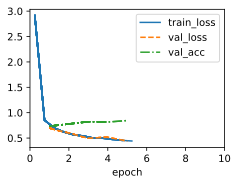

In [ ]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
trainer.fit(model, data)